# Binoculars score exploratory data analysis

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev

import configuration as config
import functions.data_manipulation as data_funcs

/mnt/arkk/llm_detector/llm_detector_benchmarking


# Hans et al. (2024) Datasets

In [14]:
hans_datasets={
    'falcon7': {
        'cc_news': 'cc_news/cc_news-falcon7.jsonl',
        'cnn': 'cnn/cnn-falcon7.jsonl',
        'pubmed': 'pubmed/pubmed-falcon7.jsonl'
    },
    'llama2-13b': {
        'cc_news': 'cc_news/cc_news-llama2_13.jsonl',
        'cnn': 'cnn/cnn-llama2_13.jsonl',
        'pubmed': 'pubmed/pubmed-llama2_13.jsonl' 
    }
}

hans_data={
    'Record ID': [],
    'Generation model': [],
    'Data source': [],
    'Human text length (words)': [],
    'Human text': [],
    'Synthetic text': [],
    'Synthetic text length (words)': []
}

hans_datasets_metadata={
    'Generation model': [],
    'Data source': [],
    'Records': [],
    'Mean human text length (words)': [],
    'Human text length STD': [],
    'Mean synthetic text length (words)': [],
    'Synthetic text length STD': [],
}

for generation_model, datasets in hans_datasets.items():
    for data_source, datafile_name in datasets.items():

        dataset_file=f'{config.BINOCULARS_DATA_PATH}/{datafile_name}'
        record_count=1
        text_lengths=[]
        human_text_lengths=[]
        synthetic_text_lengths=[]

        print(f'Parsing {dataset_file}')

        with open(dataset_file, encoding='utf-8') as f:
            for line in f:
                record=json.loads(line)

                if human_text_keys[data_source] in list(record.keys()):

                    human_text=record[human_text_keys[data_source]]
                    synthetic_text=record[list(record.keys())[-1]]

                    human_text_length=len(human_text.split(' '))
                    synthetic_text_length=len(synthetic_text.split(' '))

                    human_text_lengths.append(human_text_length)
                    synthetic_text_lengths.append(synthetic_text_length)
                    text_lengths.append(human_text_length + synthetic_text_length)

                    record_count+=1

                    hans_data['Record ID'].append(record_count)
                    hans_data['Generation model'].append(generation_model)
                    hans_data['Data source'].append(data_source)
                    hans_data['Human text length (words)'].append(human_text_length)
                    hans_data['Human text'].append(human_text)
                    hans_data['Synthetic text length (words)'].append(synthetic_text_length)
                    hans_data['Synthetic text'].append(synthetic_text)

        print(f'{generation_model}, {data_source}: {record_count} records')

        hans_datasets_metadata['Generation model'].append(generation_model)
        hans_datasets_metadata['Data source'].append(data_source)
        hans_datasets_metadata['Records'].append(record_count)
        hans_datasets_metadata['Mean human text length (words)'].append(mean(human_text_lengths))
        hans_datasets_metadata['Human text length STD'].append(stdev(human_text_lengths))
        hans_datasets_metadata['Mean synthetic text length (words)'].append(mean(synthetic_text_lengths))
        hans_datasets_metadata['Synthetic text length STD'].append(stdev(synthetic_text_lengths))

Parsing /mnt/arkk/llm_detector/llm_detector_benchmarking/data/binoculars/cc_news/cc_news-falcon7.jsonl
falcon7, cc_news: 1169 records
Parsing /mnt/arkk/llm_detector/llm_detector_benchmarking/data/binoculars/cnn/cnn-falcon7.jsonl


falcon7, cnn: 876 records
Parsing /mnt/arkk/llm_detector/llm_detector_benchmarking/data/binoculars/pubmed/pubmed-falcon7.jsonl
falcon7, pubmed: 112 records
Parsing /mnt/arkk/llm_detector/llm_detector_benchmarking/data/binoculars/cc_news/cc_news-llama2_13.jsonl
llama2-13b, cc_news: 4714 records
Parsing /mnt/arkk/llm_detector/llm_detector_benchmarking/data/binoculars/cnn/cnn-llama2_13.jsonl
llama2-13b, cnn: 2208 records
Parsing /mnt/arkk/llm_detector/llm_detector_benchmarking/data/binoculars/pubmed/pubmed-llama2_13.jsonl
llama2-13b, pubmed: 2198 records


In [16]:
hans_data_df=pd.DataFrame.from_dict(hans_data)
hans_metadata_df=pd.DataFrame.from_dict(hans_datasets_metadata)
hans_metadata_df.head(7)

,Generation model,Data source,Records,Mean human text length (words),Human text length STD,Mean synthetic text length (words),Synthetic text length STD
0,falcon7,cc_news,1169,935.790240,775.046347,369.841610,39.872910
1,falcon7,cnn,876,967.403429,295.668681,383.460571,26.776287
2,falcon7,pubmed,112,2933.936937,1884.328293,336.387387,59.922703
3,llama2-13b,cc_news,4714,863.986845,716.515544,330.481434,39.772044
4,llama2-13b,cnn,2208,893.908473,296.323984,570.213412,133.191800
5,llama2-13b,pubmed,2198,3257.725080,2587.036147,579.649522,130.517106


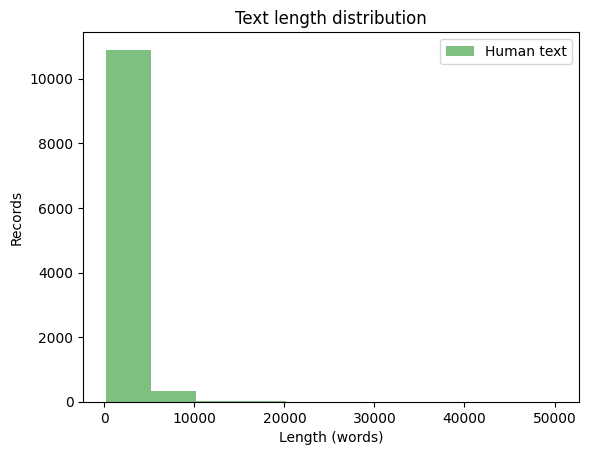

In [21]:
plt.title('Text length distribution')
plt.hist(hans_data_df['Human text length (words)'], facecolor='green', label='Human text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Length (words)')
plt.ylabel('Records')
plt.show()

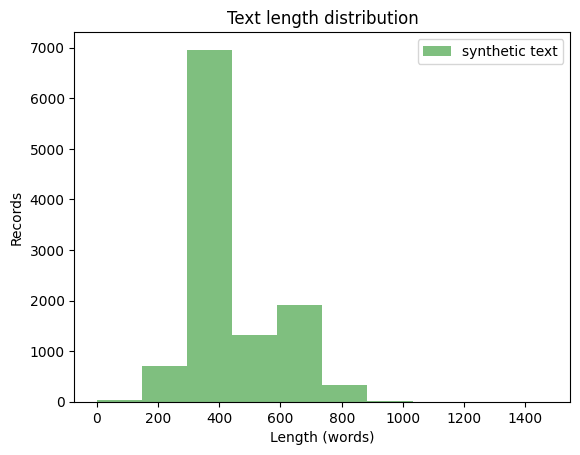

In [20]:
plt.title('Text length distribution')
plt.hist(hans_data_df['Synthetic text length (words)'], facecolor='green', label='synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Length (words)')
plt.ylabel('Records')
plt.show()

In [7]:
# Load the data
data_df=pd.read_json(f'{config.BINOCULARS_DATA_PATH}/scores.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace=True)
data_df.replace('OOM', np.nan, inplace=True)
data_df.dropna(inplace=True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Binoculars score': float
})

data_df.head()

,Fragment,Fragment length (tokens),Dataset,Source,String,Observer peak memory (GB),Performer peak memory (GB),Perplexity,Cross-perplexity,Binoculars score
0,0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,8.788764,8.407716,0.971085,1.146746,0.846818
1,1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,9.313082,8.870106,1.185710,1.238428,0.957431
2,2,290,cc_news-falcon7,human,reposted in violation of US and international ...,9.649355,9.166646,1.212603,1.270731,0.954256
3,3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,7.864891,7.606767,1.285289,1.332959,0.964237
4,4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,8.818250,8.434258,1.272878,1.475142,0.862886


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22109 entries, 0 to 22810
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fragment                    22109 non-null  int64  
 1   Fragment length (tokens)    22109 non-null  int64  
 2   Dataset                     22109 non-null  object 
 3   Source                      22109 non-null  object 
 4   String                      22109 non-null  object 
 5   Observer peak memory (GB)   22109 non-null  float64
 6   Performer peak memory (GB)  22109 non-null  float64
 7   Perplexity                  22109 non-null  float64
 8   Cross-perplexity            22109 non-null  float64
 9   Binoculars score            22109 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.9+ MB


In [8]:
datasets=data_df['Dataset'].unique()
print(f'Datasets: {datasets}')

Datasets: ['cc_news-falcon7' 'cc_news-llama2-13']


In [9]:
human_fragments=data_df[data_df['Source'] == 'human']
synthetic_fragments=data_df[data_df['Source'] == 'synthetic']

## Perplexity vs cross-perplexity

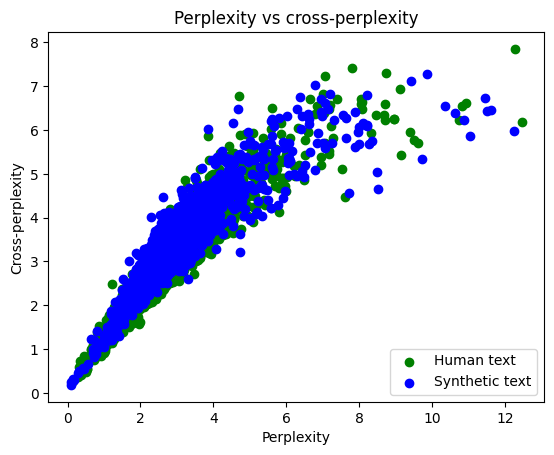

In [10]:
plt.title('Perplexity vs cross-perplexity')
plt.scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c='green', label='Human text')
plt.scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c='blue', label='Synthetic text')
plt.legend(loc='lower right')
plt.xlabel('Perplexity')
plt.ylabel('Cross-perplexity')
plt.show()

## Binoculars score distribution

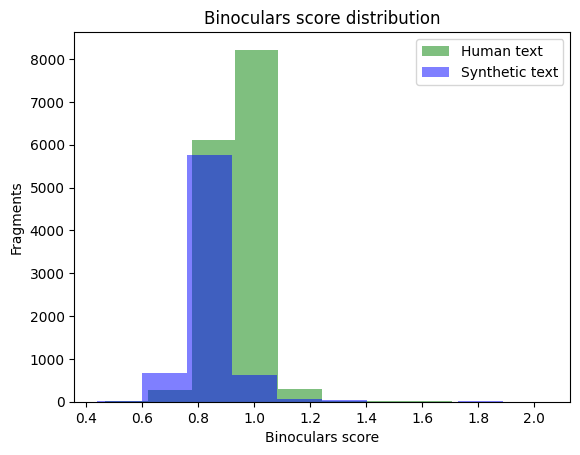

In [11]:
plt.title('Binoculars score distribution')
plt.hist(human_fragments['Binoculars score'], facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_fragments['Binoculars score'], facecolor='blue', label='Synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Binoculars score')
plt.ylabel('Fragments')
plt.show()

## Binoculars score by fragment length

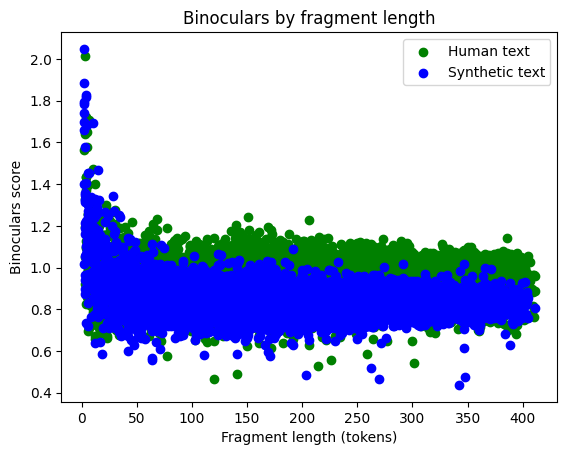

In [12]:
plt.title('Binoculars by fragment length')
plt.scatter(human_fragments['Fragment length (tokens)'], human_fragments['Binoculars score'], c='green', label='Human text')
plt.scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Binoculars score'], c='blue', label='Synthetic text')
plt.legend(loc='upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Binoculars score')
plt.show()

## Fragment length distribution

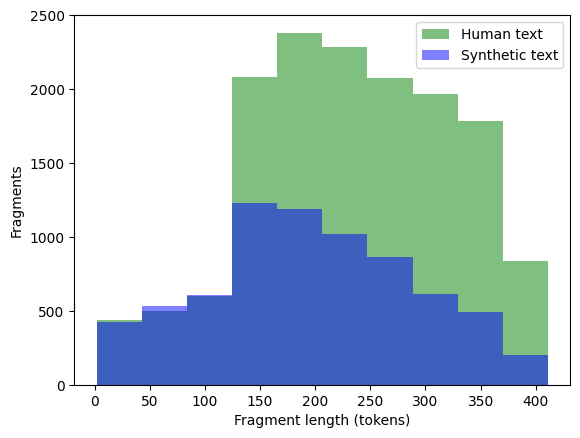

In [13]:
plt.hist(human_fragments['Fragment length (tokens)'], facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_fragments['Fragment length (tokens)'], facecolor='blue', label='Synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Fragments')
plt.show()

## Brainstorming
Ok, let's pause for a second and think through the next move(s). Really need to get to a MVP quickly here. There is a lot of stuff that needs to be decided/figured out and I think we are in one of those situations were we need to get there to know what to focus on. It's too easy to get stuck making plots and running benchmarks - we need a path to a product that works because the meat of the challenge here is going to be figuring out how to deploy and present this thing. We can tweak the models etc. later.

I think rather than continuing to tune and tweak the back-end, what we need to do is set-up and API that computes this score. Then we can start thinking about how to present it. Here are some ideas:

1. Chat-bot/server/room - users can message the bot with text and it replies with analysis/verdict, or users just post text in a room/thread and the bot replies.
2. Web page - paste in text, get analysis.
3. Browser extension - flags synthetic text on web-pages.

I think the best/easiest way to set this up is as a messaging service. Users send text they want to test to a WhatsApp/Telegram/Discord etc. contact and the bot replies with the analysis. To start with we don't need any chat functionality or anything else, but that kind of thing would be easy to add later. Also, we already have bot code for matrix and discord which we could easily adapt for this.

OK, so what do we need? I think it's basically three things:

1. The scoring/report generation function. Takes some text, does the magic, returns the answer.
2. A flask API which exposes the scoring function - probably put all of that in a docker container.
3. A communicator bot for each text service we want to use - collects suspect text from user, calls the scoring function API, sends the answer back to the user.